In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

import collections
from types import SimpleNamespace

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / ccsds.GreedyBytes
)

In [2]:
frames = np.fromfile('hakuto_frames_20221211_224843Z.u8', 'uint8').reshape(-1, 5*223-2)
frames.shape

(107, 1113)

## AOS frames

Frames are AOS frames using spacecraft ID `0x38` (assigned to [HAKUTO-R-L1 in SANA registry](https://sanaregistry.org/r/spacecraftid/records/15087)). Only virtual channel 2 is in use. There is no Operational Control Field or Insert Zone.

In [3]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames]
scid = [a.spacecraft_id for a in aos]
vcid = np.array([a.virtual_channel_id for a in aos])
vcfc = np.array([a.virtual_channel_frame_count for a in aos])
aos[:5]

[Container(transfer_frame_version_number=1, spacecraft_id=56, virtual_channel_id=2, virtual_channel_frame_count=11857, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=56, virtual_channel_id=2, virtual_channel_frame_count=11858, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=56, virtual_channel_id=2, virtual_channel_frame_count=11859, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=56, virtual_channel_id=2, virtual_channel_frame_count=11860, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=56, virtual_channel_id=2, virtual_channel_frame_count=11861, replay_flag=False, vc_frame_count_usage_flag=

In [4]:
collections.Counter(scid)

Counter({56: 107})

In [5]:
collections.Counter(vcid)

Counter({2: 107})

In [6]:
vc_seq = {vc: None for vc in set(vcid)}
master_counter = np.empty(frames.shape[0], 'int')
for j, a in enumerate(aos):
    vc = a.virtual_channel_id
    cnt = a.virtual_channel_frame_count
    if vc_seq[vc] is None:
        vc_seq[vc] = cnt
        incr = 1
    else:
        incr = cnt - vc_seq[vc]
        vc_seq[vc] = cnt
    if j == 0:
        m = 0
    else:
        m = incr + master_counter[j - 1]
    master_counter[j] = m

In [7]:
lost_frames = np.sum(np.diff(master_counter) - 1)
lost_frames

0

In [8]:
frame_duration = (5 * 8 * 223 + 4 + 32) * 2 / 16e3
frame_duration

1.1195

In [9]:
t_start = np.datetime64('2022-12-11T22:48:43')
t_frame = t_start + (frame_duration * 1e9 * master_counter) * np.timedelta64(1, 'ns')

## VC 2

Virtual channel 2 contains CCSDS Space Packets using M_PDU. There are the following APIDs in use: 136, 264, 1855, and 2047 (the only idle data APID). Packets in APID have variable size, their data zone is filled with `0xdc`, and they have no secondary header. Packets in the remaining APIDs are fixed size (per APID) and have secondary header. Packets in APIDs 136 and 264 have data length 61, while packets in APID 1855 have data length 874. APID 1855 seems to corresponds to real-time telemetry, and contains ADCS data.

In [10]:
frame_loss_vc2 = np.sum(np.diff(vcfc[vcid == 2]) - 1)
frame_loss_vc2

0

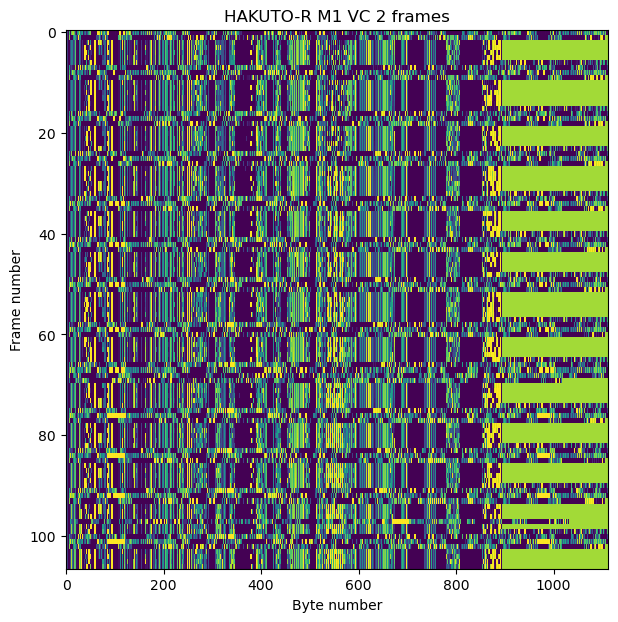

In [11]:
plt.figure(figsize=(7, 7))
plt.imshow(frames[vcid == 2], aspect='auto', interpolation='none')
plt.title('HAKUTO-R M1 VC 2 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [12]:
frames_vc2 = []
for f, t in zip(frames[vcid == 2], t_frame[vcid == 2]):
    frame = AOSFrame.parse(f)
    # Fake that the timestamp came into the AOS insert zone,
    # since the Space Packet defragmenter gets the timestamps from there.
    setattr(frame, 'insert_zone', SimpleNamespace())
    setattr(frame.insert_zone, 'timestamp', t)
    frames_vc2.append(frame)
packets = list(ccsds.extract_space_packets(frames_vc2, 0x38, 2, get_timestamps=True))
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in packets]

In [13]:
packet_headers[:10]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1855, sequence_flags=3, packet_sequence_count_or_name=1135, data_length=874),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1855, sequence_flags=3, packet_sequence_count_or_name=1136, data_length=874),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=8),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1855, sequence_flags=3, packet_sequence_count_or_name=1137, data_length=874),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=217),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1855, sequence_flags=3, packet_sequence_count_or_name=1138, data_length=874),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047,

In [14]:
[p for p in packet_headers if p.APID not in [1855, 2047]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=136, sequence_flags=3, packet_sequence_count_or_name=1119, data_length=61),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=264, sequence_flags=3, packet_sequence_count_or_name=1105, data_length=61),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=136, sequence_flags=3, packet_sequence_count_or_name=1120, data_length=61),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=264, sequence_flags=3, packet_sequence_count_or_name=1106, data_length=61)]

In [15]:
apids = collections.Counter([p.APID for p in packet_headers])
apids

Counter({1855: 119, 2047: 69, 136: 2, 264: 2})

In [16]:
for apid in apids:
    print('APID', apid)
    print('data_lengths', collections.Counter([p.data_length for p in packet_headers if p.APID == apid]))

APID 1855
data_lengths Counter({874: 119})
APID 2047
data_lengths Counter({217: 55, 8: 12, 96: 1, 81: 1})
APID 136
data_lengths Counter({61: 2})
APID 264
data_lengths Counter({61: 2})


In [17]:
all([a == 0xdc
     for a in bytes().join([p[0][ccsds.SpacePacketPrimaryHeader.sizeof():]
                            for p in packets if ccsds.SpacePacketPrimaryHeader.parse(p[0]).APID == 2047])])

True

In [18]:
by_apid = {apid: np.array(
    [np.frombuffer(p[0][ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8') for p in packets
     if ccsds.SpacePacketPrimaryHeader.parse(p[0]).APID == apid])
    for apid in apids if apid != 2047}
by_apid_t = {apid: np.array([p[1] for p in packets
                             if ccsds.SpacePacketPrimaryHeader.parse(p[0]).APID == apid])
             for apid in apids if apid != 2047}

In [19]:
(by_apid_t[136] - t_start) / np.timedelta64(1, 's')

array([ 76.126 , 108.5915])

In [20]:
(by_apid_t[264] - t_start) / np.timedelta64(1, 's')

array([ 76.126 , 108.5915])

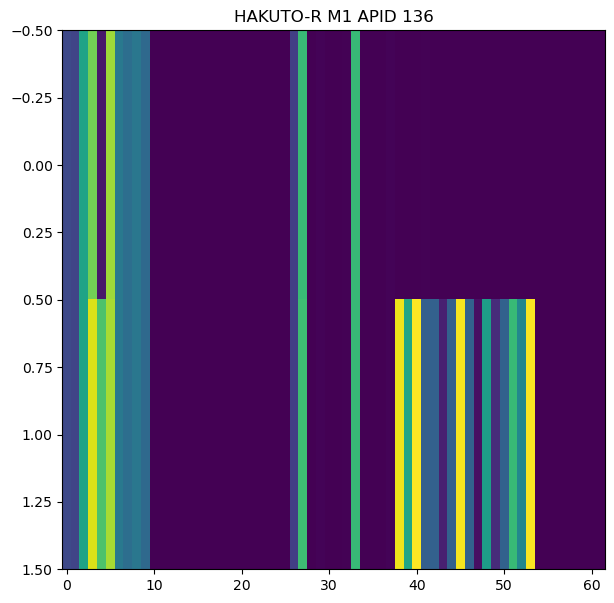

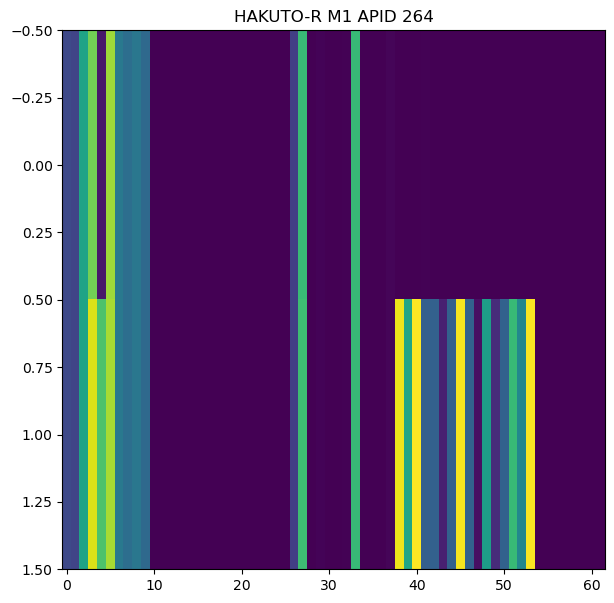

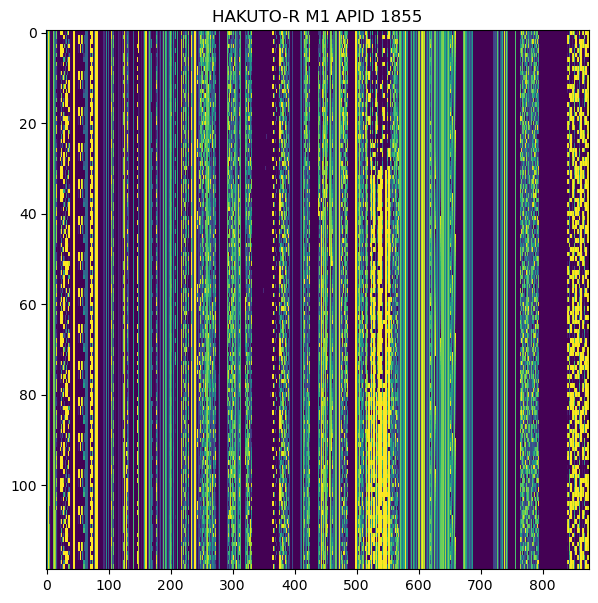

In [21]:
for apid, data in sorted(by_apid.items()):
    plt.figure(figsize=(7, 7))
    plt.imshow(data, aspect='auto', interpolation='none')
    plt.title(f'HAKUTO-R M1 APID {apid}')

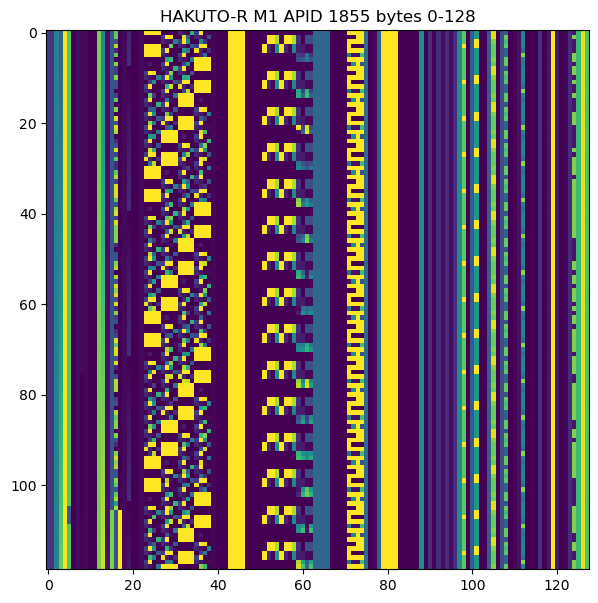

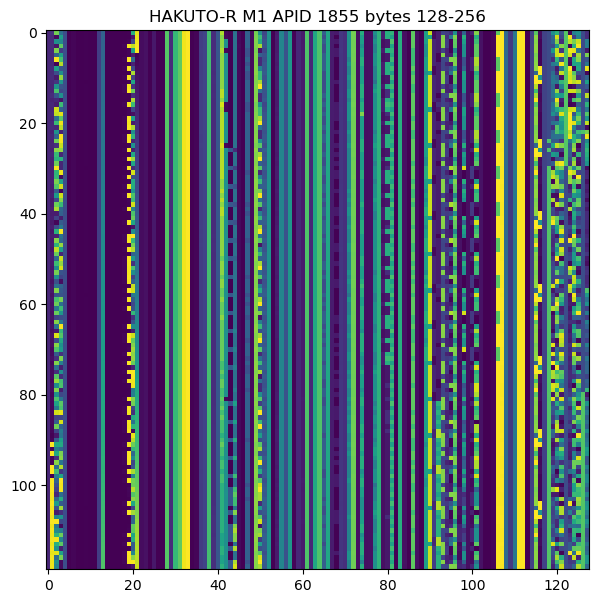

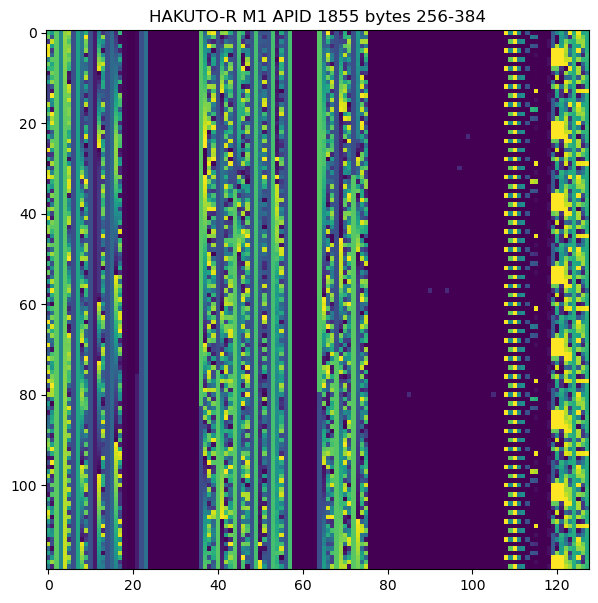

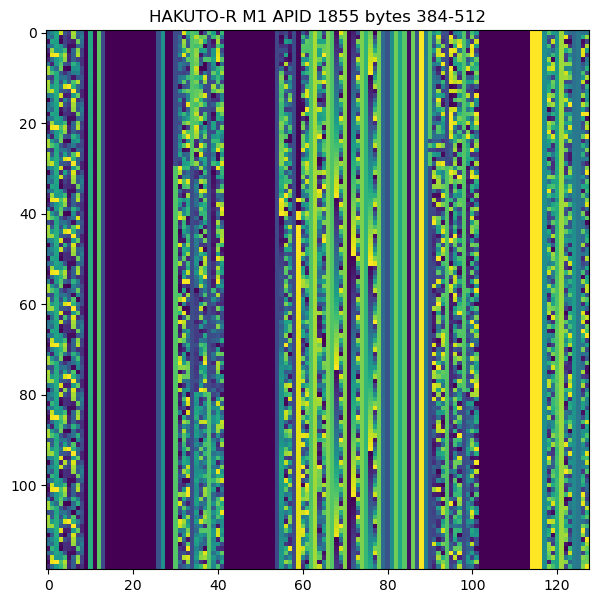

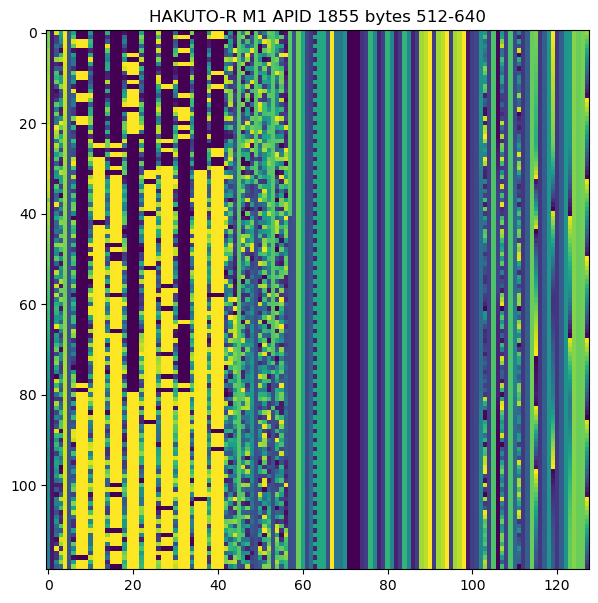

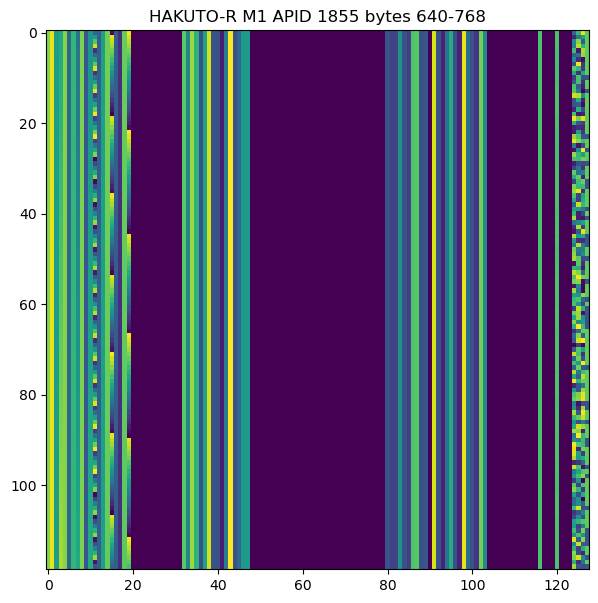

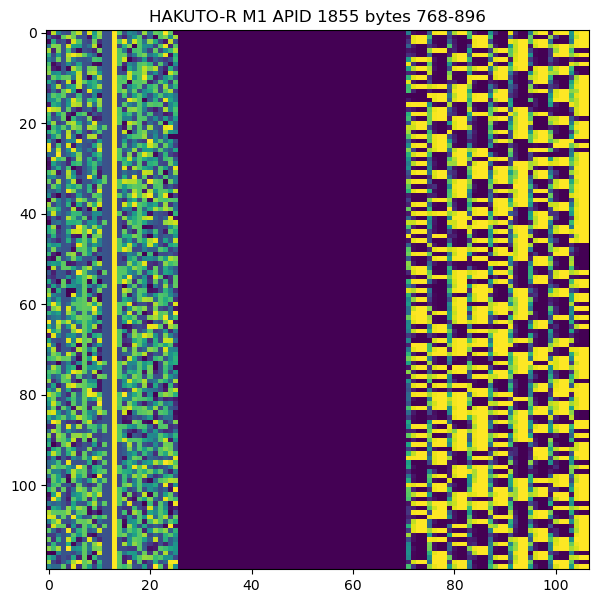

In [22]:
for j in range(0, by_apid[1855].shape[1], 128):
    plt.figure(figsize=(7, 7))
    plt.imshow(by_apid[1855][:, j:j+128], aspect='auto', interpolation='none')
    plt.title(f'HAKUTO-R M1 APID 1855 bytes {j}-{j+128}')

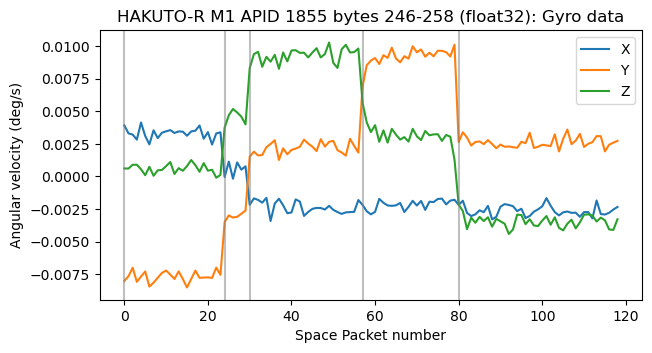

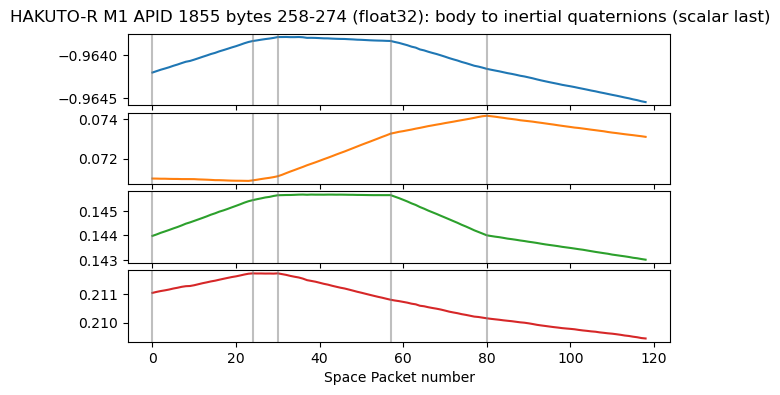

In [23]:
z = by_apid[1855][:, 246:][:, :4*7].view('float32').byteswap()

z_jumps = np.concatenate([[0], np.where(np.abs(np.diff(z[:, 2])) >= 3e-3)[0] + 1])
z_jumps

plt.plot(z[:, :3])
for jump in z_jumps:
    plt.axvline(x=jump, color='gray', alpha=0.5)
plt.title('HAKUTO-R M1 APID 1855 bytes 246-258 (float32): Gyro data')
plt.legend(['X', 'Y', 'Z'])
plt.xlabel('Space Packet number')
plt.ylabel('Angular velocity (deg/s)')

fig, axs = plt.subplots(4, 1, figsize=(7, 4), sharex=True)
for j, k in enumerate(range(3, 7)):
    axs[j].plot(z[:, k], color=f'C{j}')
    for jump in z_jumps:
        axs[j].axvline(x=jump, color='gray', alpha=0.5)
plt.subplots_adjust(hspace=0.1)
plt.suptitle('HAKUTO-R M1 APID 1855 bytes 258-274 (float32): body to inertial quaternions (scalar last)',
             y=0.94)
axs[-1].set_xlabel('Space Packet number');

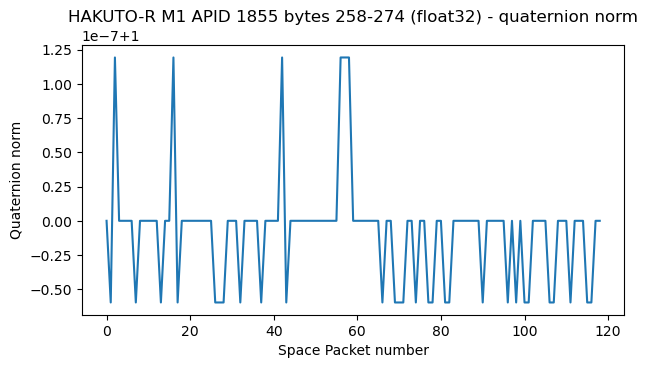

In [24]:
plt.plot(np.sum(z[:, 3:]**2, axis=1))
plt.xlabel('Space Packet number')
plt.ylabel('Quaternion norm')
plt.title('HAKUTO-R M1 APID 1855 bytes 258-274 (float32) - quaternion norm');

In [25]:
znorm = np.sqrt(np.sum(z[:, :3]**2, axis=1))
vz = z[:, :3] / znorm[:, np.newaxis]

/tmp/ipykernel_588909/3367891088.py:6: RuntimeWarning: invalid value encountered in divide
  v /= np.sqrt(np.sum(v**2, axis = -1))[..., np.newaxis]


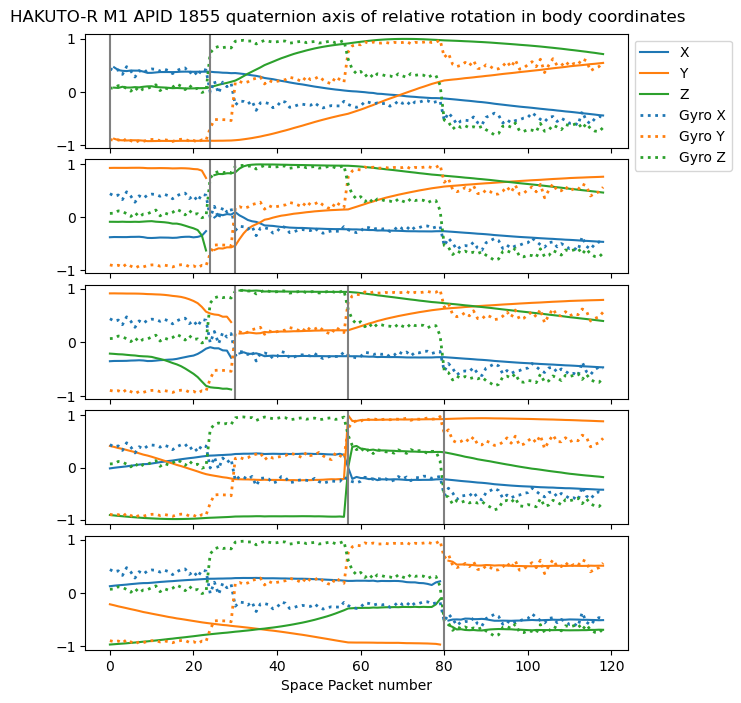

In [26]:
q = Rotation.from_quat(z[:, 3:7]) # scalar last format
# q is body -> inertial rotation
H = [q.inv()*q[jump] for jump in z_jumps] # body -> body relative rotation
V = [h.as_quat()[:,:-1] for h in H] # body axis of rotation
for v in V:
    v /= np.sqrt(np.sum(v**2, axis = -1))[..., np.newaxis]
        
fig, axs = plt.subplots(len(V), 1, figsize=(7, 8), sharex=True)
for j, v in enumerate(V):
    axs[j].plot(v)
    axs[j].set_prop_cycle(None)
    axs[j].plot(vz, ':', linewidth=2)
    axs[j].axvline(x=z_jumps[j], color='gray')
    if j != len(z_jumps) - 1:
        axs[j].axvline(x=z_jumps[j+1], color='gray')
axs[0].legend(['X', 'Y', 'Z', 'Gyro X', 'Gyro Y', 'Gyro Z'], bbox_to_anchor=[1, 1])
axs[-1].set_xlabel('Space Packet number');
plt.subplots_adjust(hspace=0.1)
plt.suptitle('HAKUTO-R M1 APID 1855 quaternion axis of relative rotation in body coordinates',
             y=0.91);

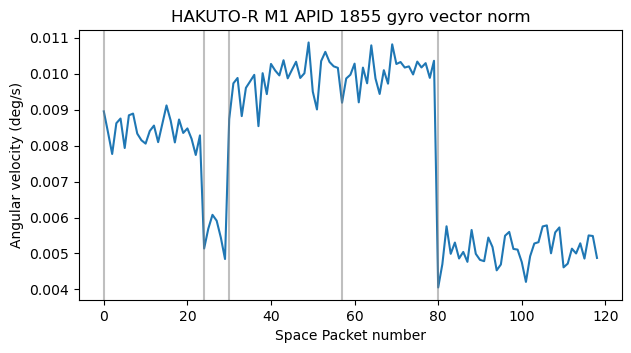

In [27]:
plt.plot(znorm)
for jump in z_jumps:
    plt.axvline(x=jump, color='gray', alpha=0.5)
plt.title('HAKUTO-R M1 APID 1855 gyro vector norm')
plt.xlabel('Space Packet number')
plt.ylabel('Angular velocity (deg/s)');

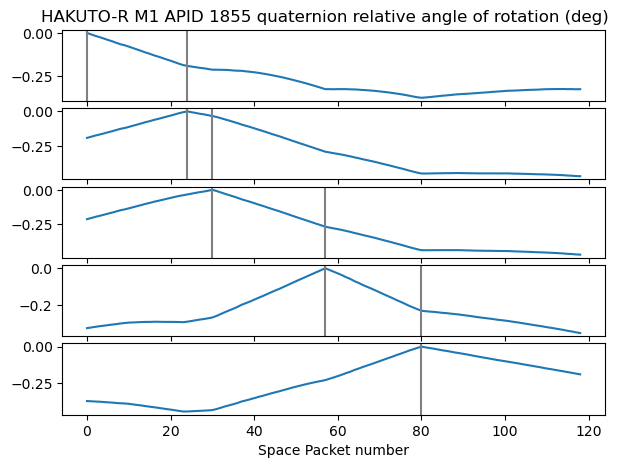

In [28]:
theta = [2 * np.arctan2(np.sqrt(np.sum(h.as_quat()[:,:-1]**2, axis = 1)), h.as_quat()[:,-1])
         for h in H]
theta = [(th + np.pi) % (2 * np.pi) - np.pi for th in theta]

fig, axs = plt.subplots(len(theta), 1, figsize=(7, 5), sharex=True)
for j, th in enumerate(theta):
    axs[j].plot(np.rad2deg(th))
    axs[j].axvline(x=z_jumps[j], color='gray')
    if j != len(z_jumps) - 1:
        axs[j].axvline(x=z_jumps[j+1], color='gray')
axs[-1].set_xlabel('Space Packet number');
plt.subplots_adjust(hspace=0.1)
plt.suptitle('HAKUTO-R M1 APID 1855 quaternion relative angle of rotation (deg)',
             y=0.92);

In [29]:
np.diff(by_apid_t[1855])

array([1119500000, 1119500000, 1119500000, 1119500000, 1119500000,
       1119500000,          0, 1119500000, 1119500000, 1119500000,
       1119500000, 1119500000, 1119500000, 1119500000, 1119500000,
       1119500000,          0, 1119500000, 1119500000, 1119500000,
       1119500000, 1119500000, 1119500000, 1119500000, 1119500000,
                0, 1119500000, 1119500000, 1119500000, 1119500000,
       1119500000, 1119500000, 1119500000, 1119500000, 1119500000,
                0, 1119500000, 1119500000, 1119500000, 1119500000,
       1119500000, 1119500000, 1119500000, 1119500000,          0,
       1119500000, 1119500000, 1119500000, 1119500000, 1119500000,
       1119500000, 1119500000, 1119500000,          0, 1119500000,
       1119500000, 1119500000, 1119500000, 1119500000, 1119500000,
       1119500000, 1119500000, 1119500000,          0, 1119500000,
       1119500000, 1119500000, 1119500000, 1119500000, 1119500000,
       1119500000, 1119500000,          0, 1119500000, 1119500

In [30]:
(by_apid_t[1855][-1] - by_apid_t[1855][0]) / (by_apid_t[1855].size - 1)

numpy.timedelta64(1005652542,'ns')

In [31]:
# gyro scale factor deg/s
z_jumps_ext = np.concatenate((z_jumps, [0]))
for j in range(len(z_jumps)):
    ang = ((theta[j][z_jumps_ext[j + 1] - 1] - theta[j][z_jumps[j]])
           / ((np.arange(theta[j].size)[z_jumps_ext[j + 1] - 1] - np.arange(theta[j].size)[z_jumps[j]])))
    scale = np.rad2deg(ang) / np.average(znorm[slice(z_jumps[j], None if (w:=z_jumps_ext[j + 1]) == 0 else w)])
    print('scale:', scale)

scale: -0.9599735753621962
scale: -0.998946997067689
scale: -1.0023061165218345
scale: -1.0045243464361615
scale: -0.9872623563156117


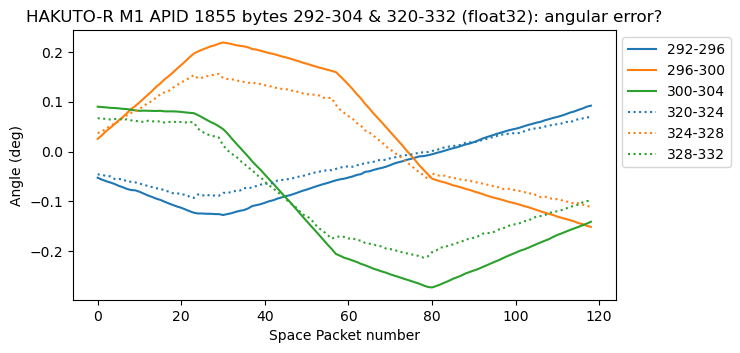

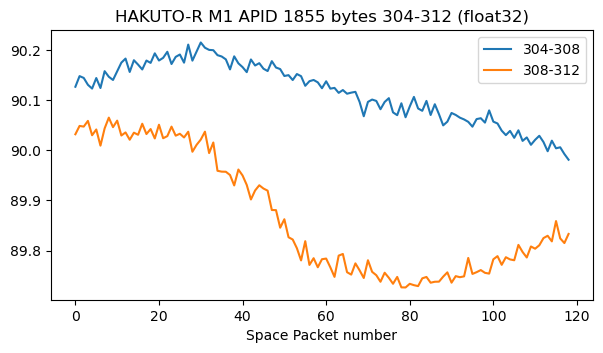

In [32]:
w = by_apid[1855][:, 292:][:, :4*5].view('float32').byteswap()
a = by_apid[1855][:, 320:][:, :4*3].view('float32').byteswap()
plt.plot(w[:, :3])
plt.gca().set_prop_cycle(None)
plt.plot(a, ':')
plt.title('HAKUTO-R M1 APID 1855 bytes 292-304 & 320-332 (float32): angular error?')
plt.legend([f'{j}-{j+4}' for j in range(292, 292+4*3, 4)] + [f'{j}-{j+4}' for j in range(320, 320+4*3, 4)],
           bbox_to_anchor=[1, 1])
plt.xlabel('Space Packet number')
plt.ylabel('Angle (deg)')
plt.figure()
plt.plot(w[:, 3:])
plt.title('HAKUTO-R M1 APID 1855 bytes 304-312 (float32)')
plt.legend([f'{j}-{j+4}' for j in range(304, 304+4*2, 4)])
plt.xlabel('Space Packet number');

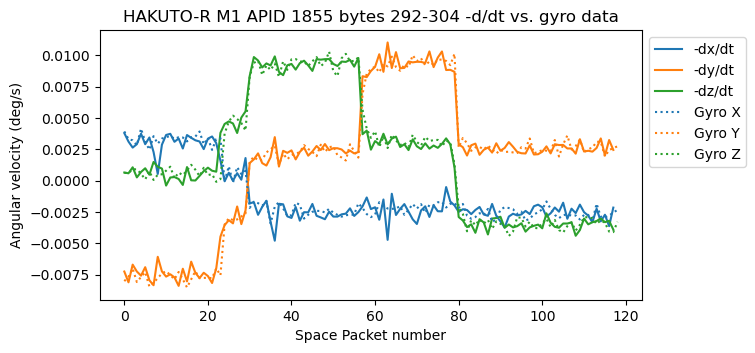

In [33]:
plt.title('HAKUTO-R M1 APID 1855 bytes 292-304 -d/dt vs. gyro data')
plt.plot(-np.diff(w[:, :3], axis=0))
plt.gca().set_prop_cycle(None)
plt.plot(z[:, :3], ':')
plt.legend(['-dx/dt', '-dy/dt', '-dz/dt', 'Gyro X', 'Gyro Y', 'Gyro Z'], bbox_to_anchor=[1, 1])
plt.ylabel('Angular velocity (deg/s)')
plt.xlabel('Space Packet number');

Text(0.5, 0, 'Space Packet number')

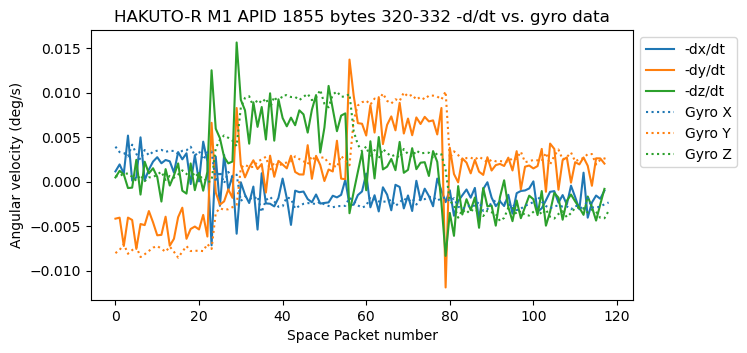

In [34]:
plt.title('HAKUTO-R M1 APID 1855 bytes 320-332 -d/dt vs. gyro data')
plt.plot(-np.diff(a[:, :3], axis=0))
plt.gca().set_prop_cycle(None)
plt.plot(z[:, :3], ':')
plt.legend(['-dx/dt', '-dy/dt', '-dz/dt', 'Gyro X', 'Gyro Y', 'Gyro Z'], bbox_to_anchor=[1, 1])
plt.ylabel('Angular velocity (deg/s)')
plt.xlabel('Space Packet number')

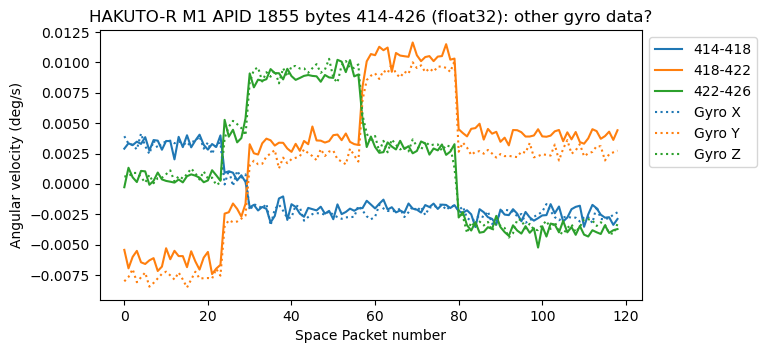

In [35]:
b = by_apid[1855][:, 414:][:, :4*3].view('float32').byteswap()
plt.plot(b)
plt.gca().set_prop_cycle(None)
plt.plot(z[:, :3], ':')
plt.title('HAKUTO-R M1 APID 1855 bytes 414-426 (float32): other gyro data?')
plt.legend([f'{j}-{j+4}' for j in range(414, 414+4*3, 4)] + ['Gyro X', 'Gyro Y', 'Gyro Z'],
           bbox_to_anchor=[1, 1])
plt.xlabel('Space Packet number')
plt.ylabel('Angular velocity (deg/s)');

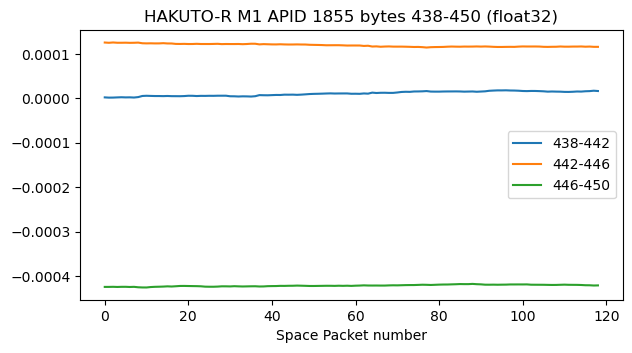

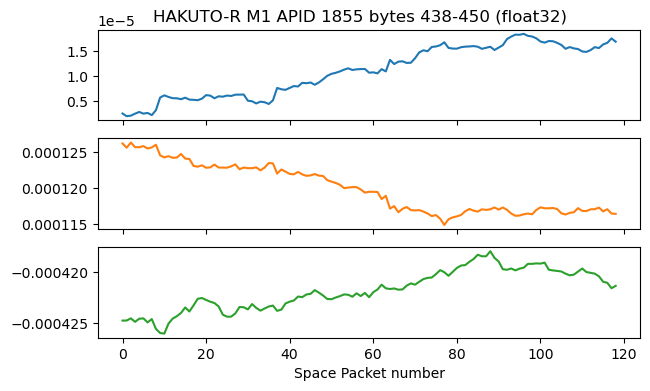

In [36]:
c = by_apid[1855][:, 438:][:, :4*3].view('float32').byteswap()
plt.figure()
plt.plot(c)
plt.title('HAKUTO-R M1 APID 1855 bytes 438-450 (float32)')
plt.xlabel('Space Packet number')
plt.legend([f'{j}-{j+4}' for j in range(438, 438+4*3, 4)])
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 4))
for j in range(c.shape[1]):
    axs[j].plot(c[:, j], color=f'C{j}')
axs[-1].set_xlabel('Space Packet number')
plt.suptitle('HAKUTO-R M1 APID 1855 bytes 438-450 (float32)', y=0.93);

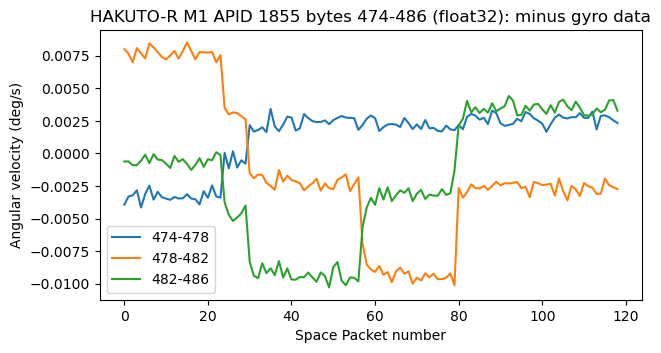

In [37]:
d = by_apid[1855][:, 474:][:, :4*3].view('float32').byteswap()
plt.figure()
plt.plot(d)
plt.title('HAKUTO-R M1 APID 1855 bytes 474-486 (float32): minus gyro data')
plt.ylabel('Angular velocity (deg/s)')
plt.xlabel('Space Packet number')
plt.legend([f'{j}-{j+4}' for j in range(474, 474+4*3, 4)]);

In [38]:
np.all(z[:, :3] == -d)

True

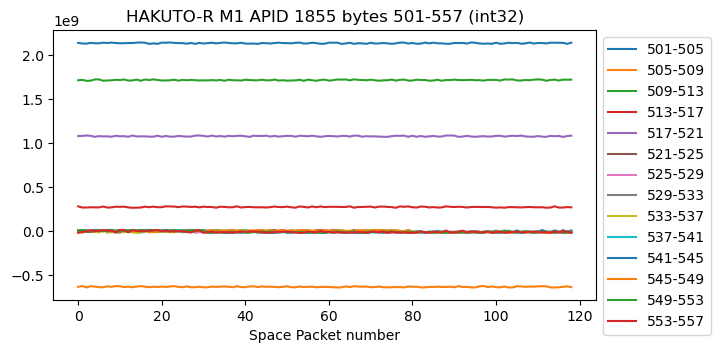

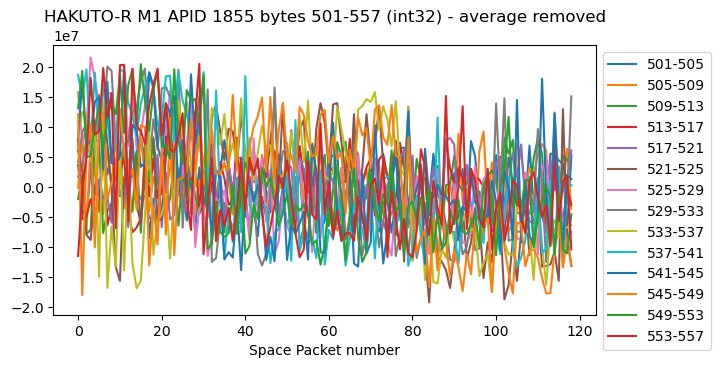

In [39]:
e = by_apid[1855][:, 501:][:, :4*14].view('int32').byteswap()
plt.figure()
plt.plot(e)
plt.title('HAKUTO-R M1 APID 1855 bytes 501-557 (int32)')
plt.xlabel('Space Packet number')
plt.legend([f'{j}-{j+4}' for j in range(501, 557, 4)], bbox_to_anchor=[1, 1])
plt.figure()
plt.plot(e - np.average(e.astype('float'), axis=0))
plt.title('HAKUTO-R M1 APID 1855 bytes 501-557 (int32) - average removed')
plt.xlabel('Space Packet number')
plt.legend([f'{j}-{j+4}' for j in range(501, 557, 4)], bbox_to_anchor=[1, 1]);

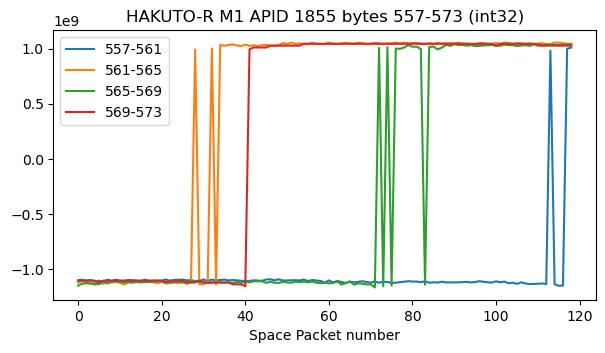

In [40]:
f = by_apid[1855][:, 557:][:, :4*4].view('int32').byteswap()
plt.figure()
plt.plot(f)
plt.title('HAKUTO-R M1 APID 1855 bytes 557-573 (int32)')
plt.xlabel('Space Packet number')
plt.legend([f'{j}-{j+4}' for j in range(557, 573, 4)]);